In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
%matplotlib inline

In [2]:
trips_df = pd.read_pickle('../00_data/trips_with_hourly_features.pkl')
trips_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 225627 entries, 19 to 290340
Data columns (total 12 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   duration      225627 non-null  float64
 1   distance      225627 non-null  float64
 2   speed         225627 non-null  float64
 3   temp          225627 non-null  float64
 4   precip        225627 non-null  float64
 5   hour_start    225627 non-null  int64  
 6   day_of_week   225627 non-null  int64  
 7   month         225627 non-null  int64  
 8   is_weekday    225627 non-null  int64  
 9   is_holiday    225627 non-null  int64  
 10  duration_min  225627 non-null  float64
 11  hour_end      225627 non-null  int64  
dtypes: float64(6), int64(6)
memory usage: 22.4 MB


In [3]:
trips_df.head(2)

,duration,distance,speed,temp,precip,hour_start,day_of_week,month,is_weekday,is_holiday,duration_min,hour_end
19,80.0,0.000000,0.000000,15.6,0.0,1,1,1,1,1,80.0,2
20,4.0,0.156355,2.345331,15.6,0.0,1,1,1,1,1,4.0,1


In [6]:
#Testing different features here
#trips_df = trips_df[['distance', 'speed','hour_end','temp','precip','hour_start','day_of_week','month','duration_min']].copy()

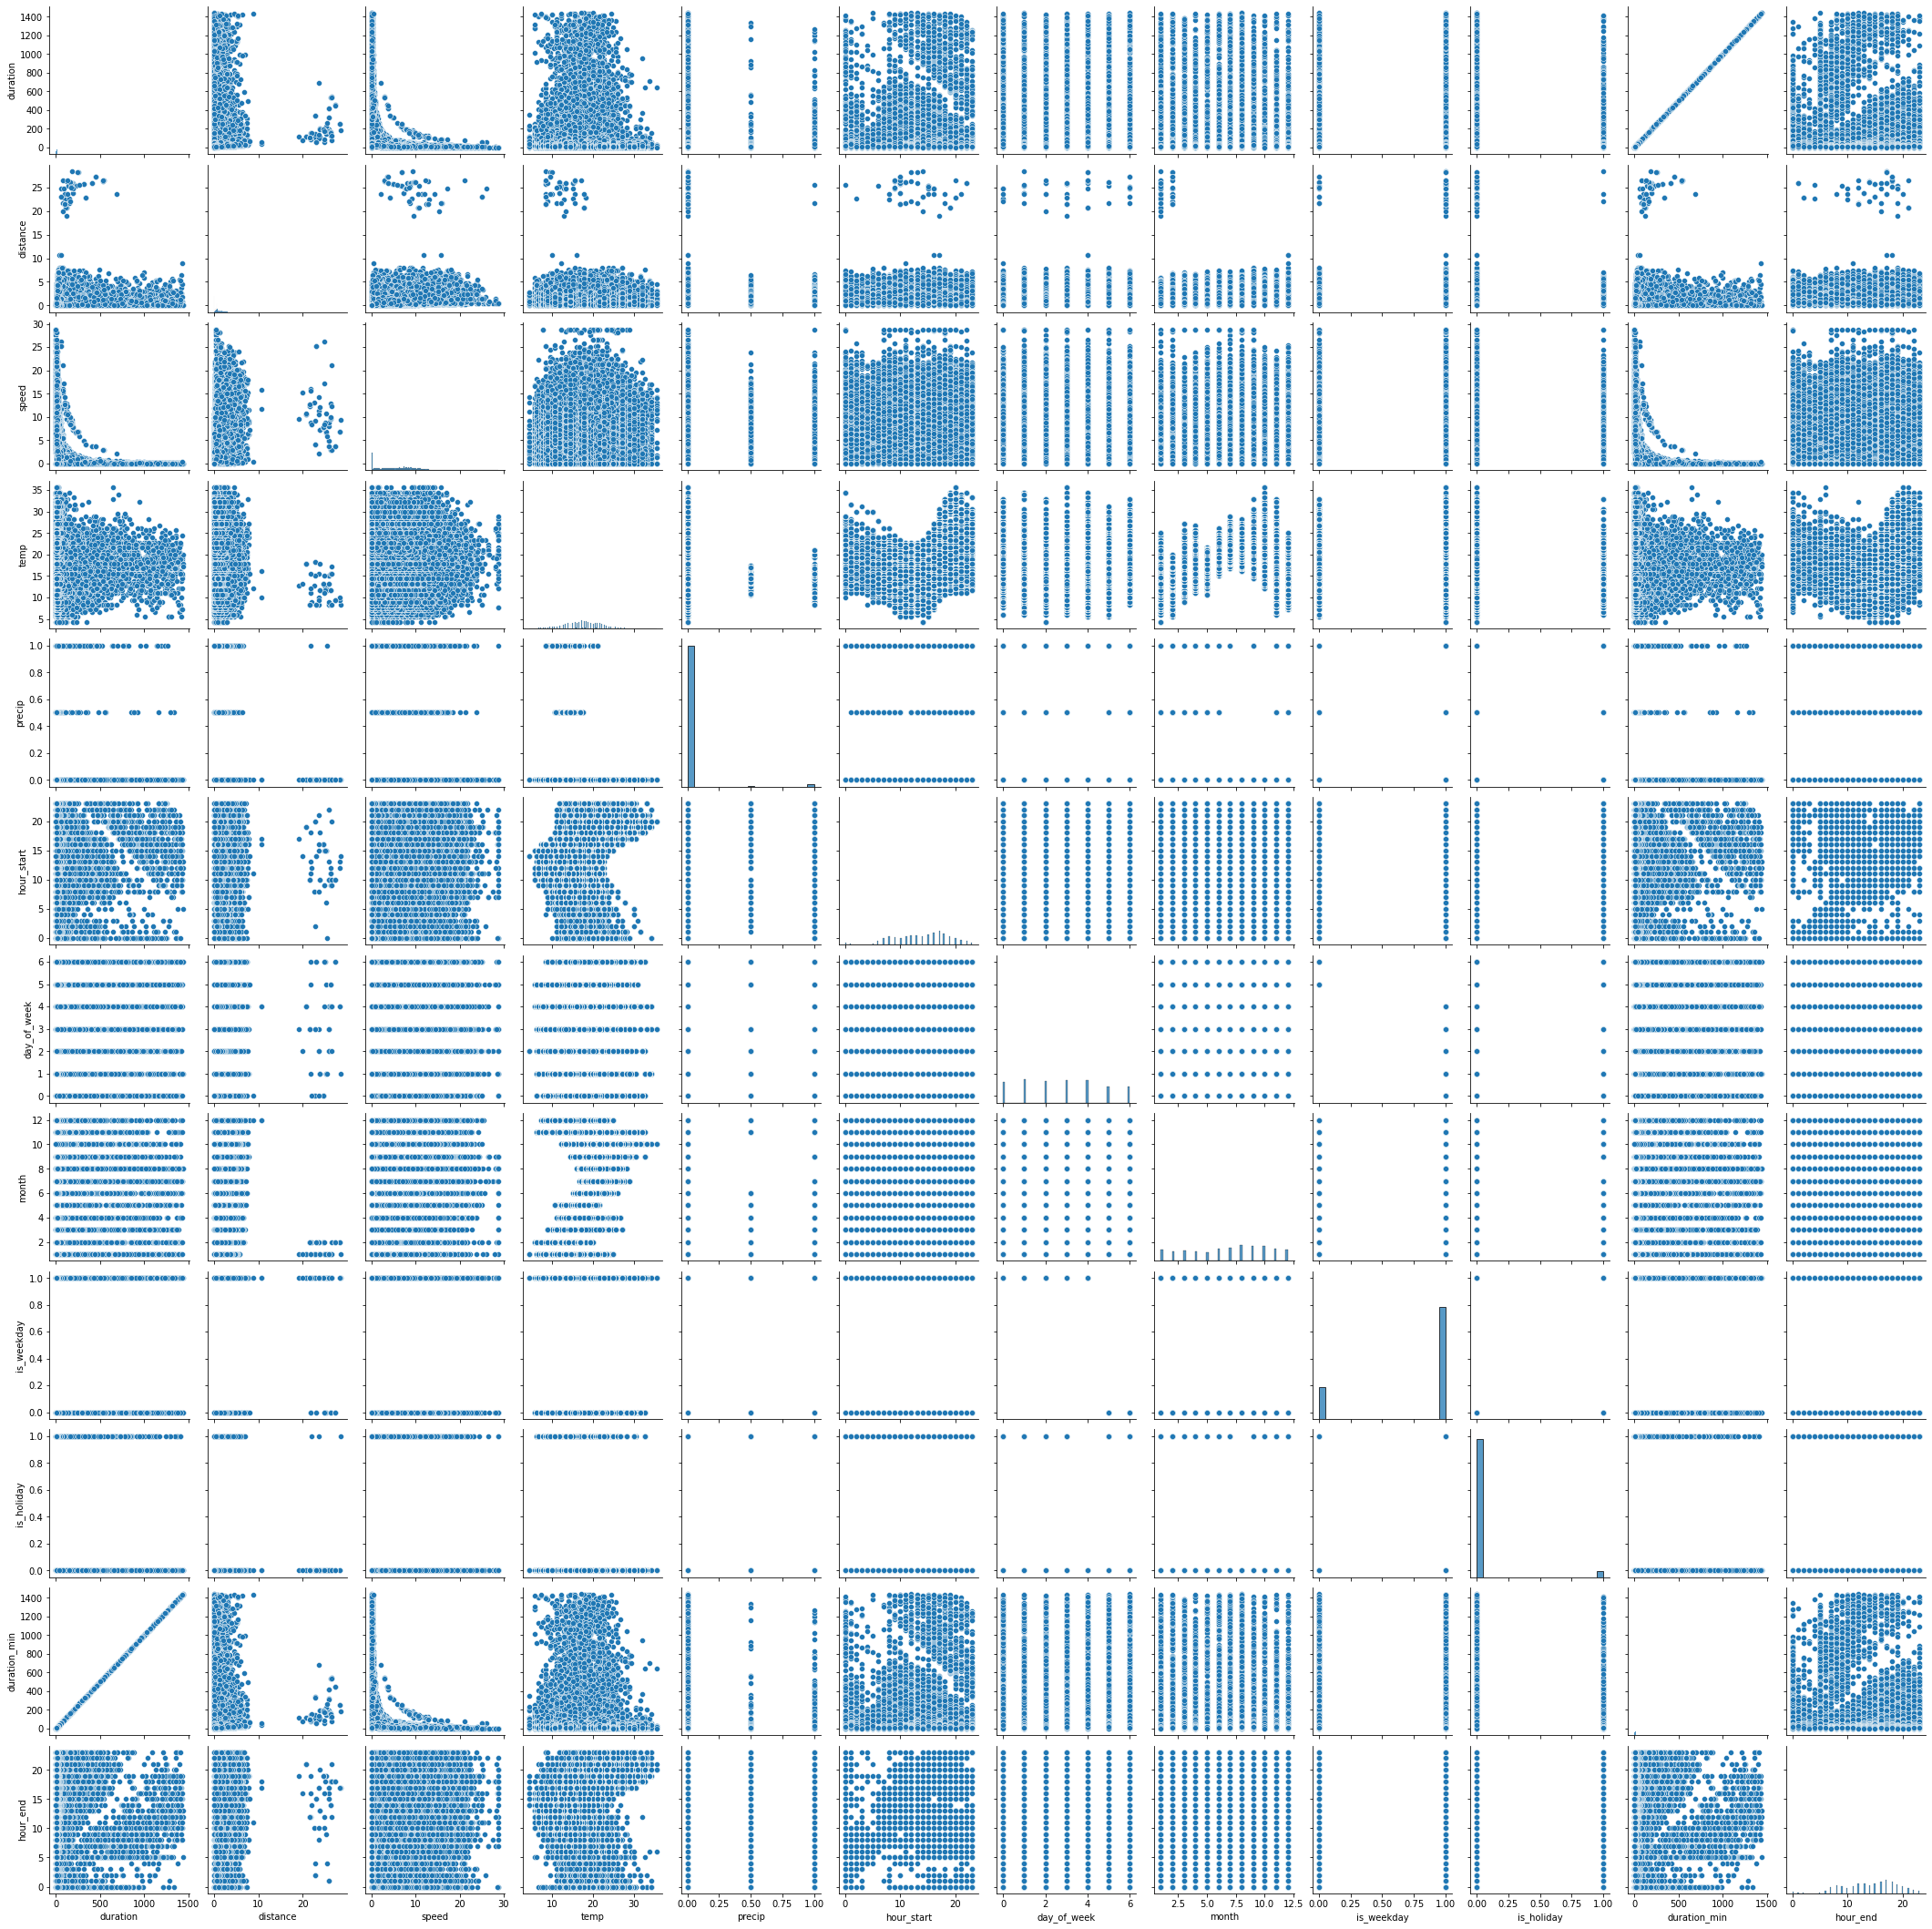

In [5]:
sns.pairplot(data=trips_df)

In [7]:
#X=trips_df TODO Feature selection -> datetime format problem
X = trips_df
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)
X_scaled_df.head()

,duration,distance,speed,temp,precip,hour_start,day_of_week,month,is_weekday,is_holiday,duration_min,hour_end
19,0.795684,-1.050004,-1.426842,-0.453807,-0.148258,-2.662604,-0.934522,-1.754357,0.53487,4.778389,0.795684,-2.446509
20,-0.245179,-0.893602,-0.888913,-0.453807,-0.148258,-2.662604,-0.934522,-1.754357,0.53487,4.778389,-0.245179,-2.648989
21,0.768293,-1.050004,-1.426842,-0.453807,-0.148258,-2.662604,-0.934522,-1.754357,0.53487,4.778389,0.768293,-2.446509
22,0.206775,1.981254,-0.299740,-0.453807,-0.148258,-2.662604,-0.934522,-1.754357,0.53487,4.778389,0.206775,-2.446509
23,0.193079,1.981254,-0.268432,-0.453807,-0.148258,-2.662604,-0.934522,-1.754357,0.53487,4.778389,0.193079,-2.446509


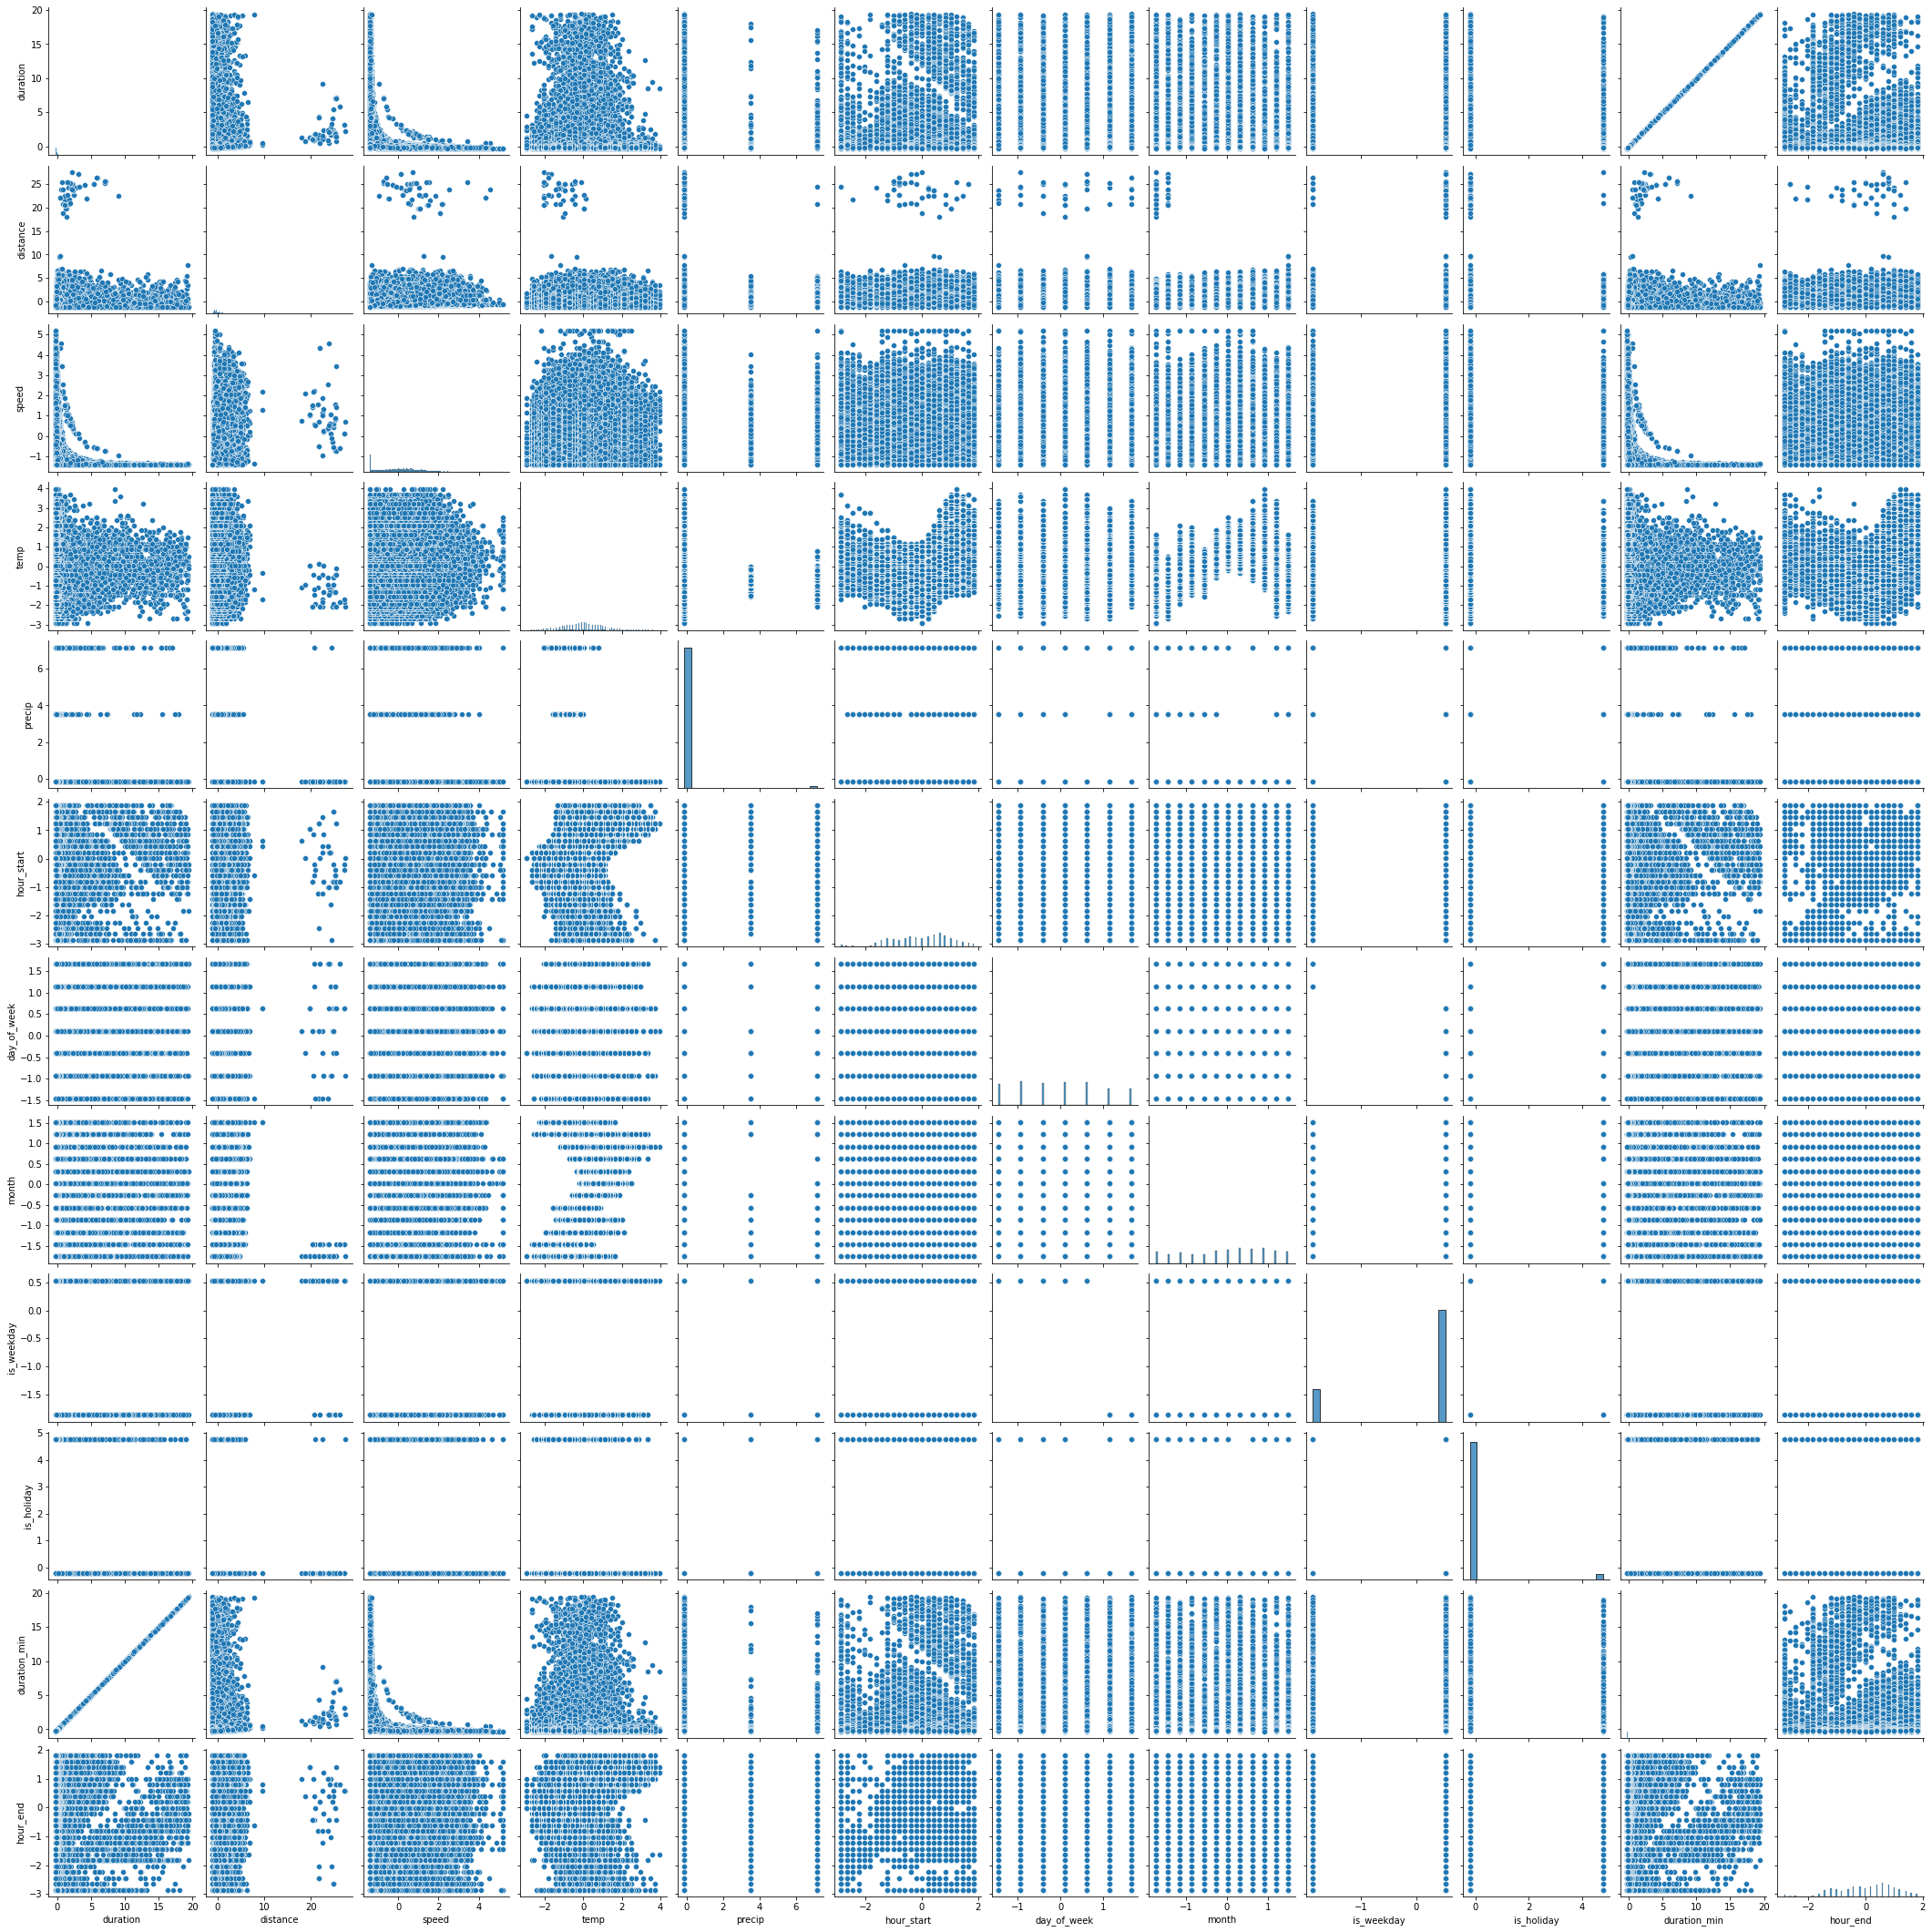

In [8]:
sns.pairplot(data=X_scaled_df)
#x.head()

# k-means


In [9]:

k_max = 20

In [10]:
clusters = []
losses = []

for k in range(k_max):
    model = KMeans(n_clusters=k+1)
    model.fit(X_scaled)
    clusters.append(k+1)
    losses.append(model.inertia_)

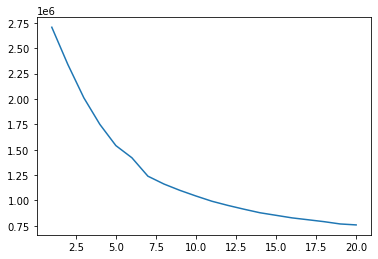

In [11]:
plt.plot(clusters, losses)
plt.show()


(0.0, 10.0)

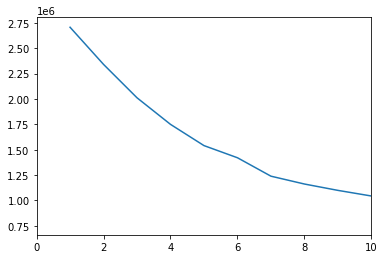

In [12]:
plt.plot(clusters, losses)
plt.xlim([0,10])


In [15]:
best_means = KMeans(n_clusters=7)
best_means.fit(X_scaled)
best_means.predict(X_scaled)

array([0, 0, 0, ..., 0, 0, 0], dtype=int32)

In [20]:
X_scaled_df["y"] = best_means.predict(X_scaled)
#sns.pairplot(data=X_scaled_df, hue="y")

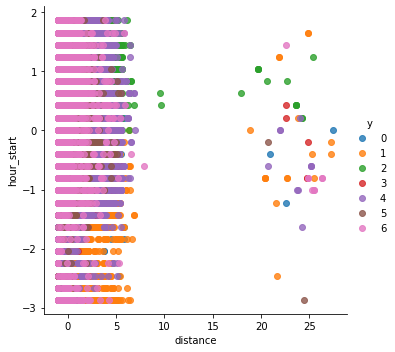

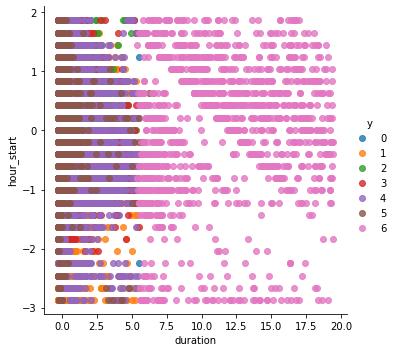

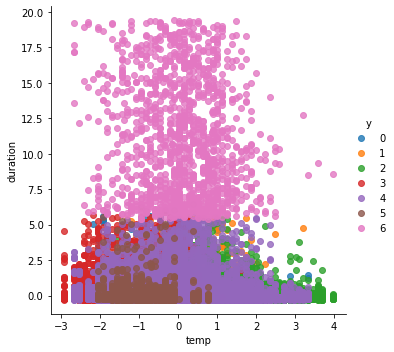

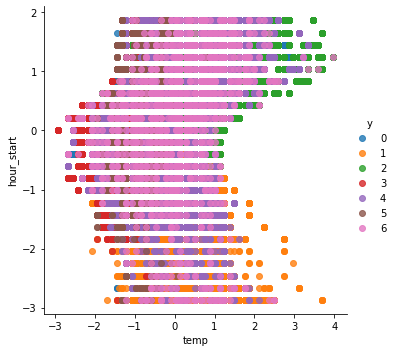

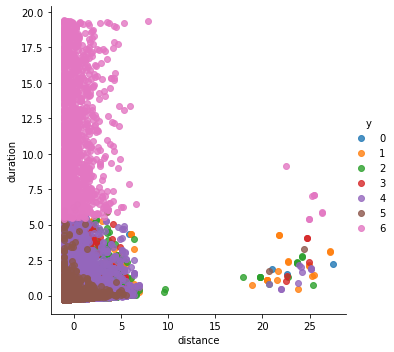

In [22]:
sns.lmplot(x="distance", y="hour_start", data=X_scaled_df, fit_reg=False, hue="y")
sns.lmplot(x="duration", y="hour_start", data=X_scaled_df, fit_reg=False, hue="y")
sns.lmplot(x="temp", y="duration", data=X_scaled_df, fit_reg=False, hue="y")
sns.lmplot(x="temp", y="hour_start", data=X_scaled_df, fit_reg=False, hue="y")
sns.lmplot(x="distance", y="duration", data=X_scaled_df, fit_reg=False, hue="y")


# with Principal Component Analysis (PCA)


In [23]:
# Scale features

scaler = StandardScaler()
trips_scaled = pd.DataFrame(scaler.fit_transform(trips_df))

In [24]:
trips_scaled.head()

,0,1,2,3,4,5,6,7,8,9,10,11
0,0.795684,-1.050004,-1.426842,-0.453807,-0.148258,-2.662604,-0.934522,-1.754357,0.53487,4.778389,0.795684,-2.446509
1,-0.245179,-0.893602,-0.888913,-0.453807,-0.148258,-2.662604,-0.934522,-1.754357,0.53487,4.778389,-0.245179,-2.648989
2,0.768293,-1.050004,-1.426842,-0.453807,-0.148258,-2.662604,-0.934522,-1.754357,0.53487,4.778389,0.768293,-2.446509
3,0.206775,1.981254,-0.299740,-0.453807,-0.148258,-2.662604,-0.934522,-1.754357,0.53487,4.778389,0.206775,-2.446509
4,0.193079,1.981254,-0.268432,-0.453807,-0.148258,-2.662604,-0.934522,-1.754357,0.53487,4.778389,0.193079,-2.446509


In [25]:
# Run PCA to reduce dimensionality
pca = PCA(n_components=4)
trips_scaled_pca = pca.fit_transform(trips_scaled)

In [26]:
sum(pca.explained_variance_ratio_)

0.6210725813891773

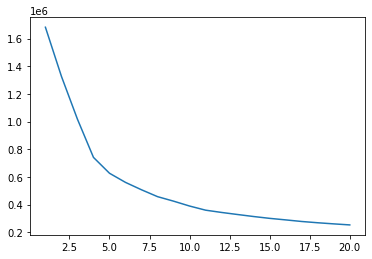

In [27]:
clusters = []
losses = []

for i in range(k_max):
    model = KMeans(n_clusters=i+1)
    model.fit(trips_scaled_pca)
    clusters.append(i+1)
    losses.append(model.inertia_)

plt.plot(clusters, losses)
plt.show()

(0.0, 10.0)

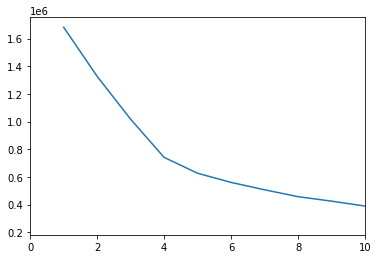

In [28]:
plt.plot(clusters, losses)
plt.xlim([0,10])

In [29]:
best_kmeans = KMeans(n_clusters=4)
best_kmeans.fit(trips_scaled_pca)

KMeans(n_clusters=4)

In [30]:
best_kmeans.predict(trips_scaled_pca)

array([1, 1, 1, ..., 3, 3, 3], dtype=int32)

In [31]:
trips_scaled_pca_df = pd.DataFrame(trips_scaled_pca, index=trips_df.index)
trips_scaled_pca_df.columns = ["PC"+str(column+1) for column in trips_scaled_pca_df.columns]

In [32]:
trips_scaled_pca_df["y"] = best_kmeans.predict(trips_scaled_pca)

trips_scaled_pca_df.head()

,PC1,PC2,PC3,PC4,y
19,-1.097386,3.723844,0.813234,-2.086128,1
20,-2.310752,2.909521,0.235648,-2.050223,1
21,-1.122278,3.700953,0.798086,-2.094803,1
22,-2.300917,3.145520,0.681744,0.020447,1
23,-2.323864,3.131246,0.675431,0.031079,1


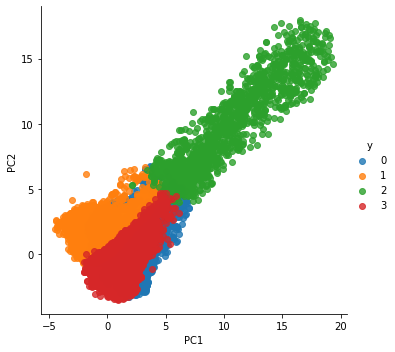

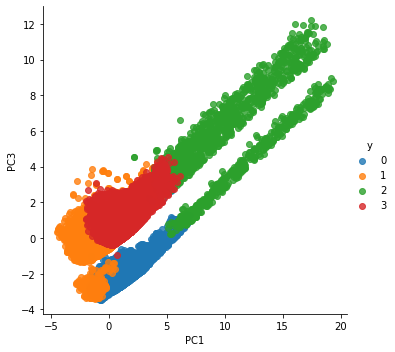

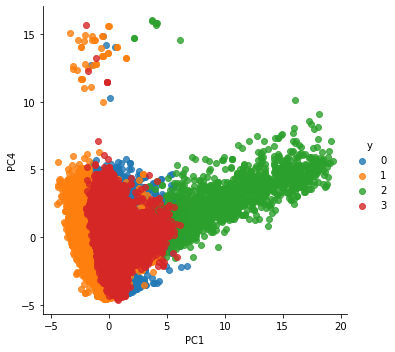

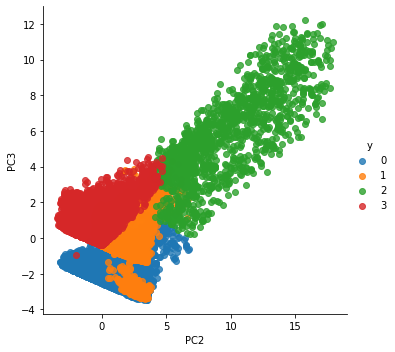

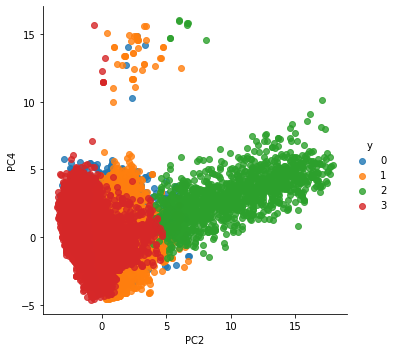

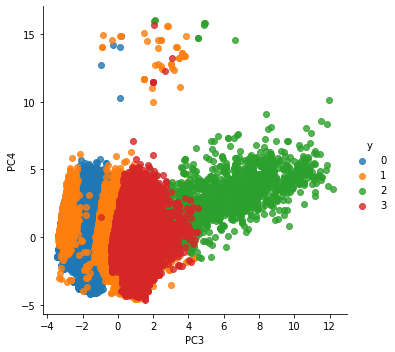

In [33]:
sns.lmplot(x="PC1", y="PC2", data=trips_scaled_pca_df, fit_reg=False, hue="y")
sns.lmplot(x="PC1", y="PC3", data=trips_scaled_pca_df, fit_reg=False, hue="y")
sns.lmplot(x="PC1", y="PC4", data=trips_scaled_pca_df, fit_reg=False, hue="y")
sns.lmplot(x="PC2", y="PC3", data=trips_scaled_pca_df, fit_reg=False, hue="y")
sns.lmplot(x="PC2", y="PC4", data=trips_scaled_pca_df, fit_reg=False, hue="y")
sns.lmplot(x="PC3", y="PC4", data=trips_scaled_pca_df, fit_reg=False, hue="y")

# Hierarchical Clustering

In [ ]:
# Todo